# Importing libraries

In [1]:
%matplotlib inline

import sympy
from sympy.solvers import solve
from sympy import *
from sympy.parsing.sympy_parser import parse_expr
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import model_from_json

# Loading the pre-trained model

In [2]:
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")

# Some helper functions 

In [3]:
classes = ['0','1','2','3','4','5','6','7','8','9','-','+','=','x','y']

In [4]:
def manipulate_string(string_list):
    variables = ['x','y']
    numbers = ['0','1','2','3','4','5','6','7','8','9']
    for i in range(len(string_list)):
        s= list(string_list[i])
        index_of_eq = s.index('=')
        if int(s[index_of_eq+1]) == 0:
            s=s[:index_of_eq]
        else:
            s=['-' if i == '=' else i for i in s]

        string_list[i]=s

    #print(answer)
    for j in range(len(string_list)):
        s=string_list[j]
        for i in range(len(s)):
            if s[i] in variables:
                if s[i+1] in numbers:
                    s.insert(i+1,'**')
                if i!=0 and s[i-1] in numbers:
                    s.insert(i,'*')
            else:
                continue
        string_list[j]=''.join(s)
    
    return string_list


In [40]:
def find_indi(image):
    #image = second 

    kernel = np.ones((20,5), np.uint8)

    first_dil = cv2.dilate(image, kernel, iterations=1)

    ctrs, hier = cv2.findContours(first_dil.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sorted_ctrs = sorted(ctrs, key = lambda ctr: cv2.boundingRect(ctr)[0])

    chars = np.zeros((1,28,28))
    for i in range(len(sorted_ctrs)):    
        x,y,w,h = cv2.boundingRect(sorted_ctrs[i])
        tt = image[y:y+h, x:x+w]
        tt = cv2.resize(tt, (28,28), interpolation = cv2.INTER_NEAREST)
        tt = tt[np.newaxis,:]
        chars = np.concatenate((chars, tt))

    return np.concatenate((chars[1:], np.zeros((1,28,28))))

# Input image preprocessing 

Input image:



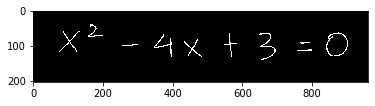

In [98]:
img = cv2.imread('test/quad.jpeg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.fastNlMeansDenoising(gray_img, None, 21,7, 21) 
ret, thresh = cv2.threshold(gray_img2, 150, 255, cv2.THRESH_BINARY_INV)

kernel = np.ones((5,200), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
print("Input image:\n")
plt.imshow(thresh, cmap = 'gray')

In [99]:
ctrs_line, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs_line = sorted(ctrs_line, key = lambda ctr: cv2.boundingRect(ctr)[1])
a = np.zeros((1,28,28))
for i in sorted_ctrs_line:
    x,y,w,h = cv2.boundingRect(i)
    #plt.imshow(img_dilation[y:y+h,x:x+w])
    chars = find_indi(thresh[y:y+h, x:x+w])
    
    a = np.concatenate((a,chars))

a=a[1:]
b = a[np.newaxis, :]
b = b.reshape((b.shape[1],b.shape[0],b.shape[2],b.shape[3]))
b = b.astype('float32')
#b.shape

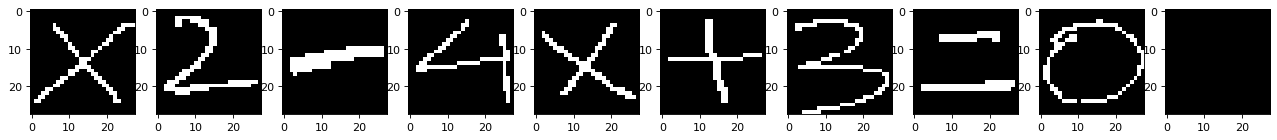

In [100]:
f = plt.figure(figsize=(20, 10), dpi = 80)
n=len(a)
for i in range(n):
    # Debug, plot figure
    f.add_subplot(1, n, i + 1)
    plt.imshow(b[i][0], cmap = 'gray')

plt.show(block=True)

# Predicting the equation(s) in the input image 

In [101]:
answer =[]
s=''
for i in range(len(b)):    
    if np.array_equal(b[i][0],np.zeros((28,28))):
        answer.append(s)
        s=''
    else:
        pred = loaded_model.predict(b[i].reshape((1,28,28,1)))
        s=s+classes[pred.argmax(axis = -1)[0]]
answer

['x2-4x+3=0']

# Answer to the predicted equation in the image

In [102]:
x = manipulate_string(answer)

expressions =[]
for ex in x:
    expressions.append(parse_expr(ex))
print('Equation(s): {}'.format(expressions)) 
print('Answer: {}'.format(solve(expressions)))

Equation(s): [x**2 - 4*x + 3]
Answer: [{x: 1}, {x: 3}]
